<a href="https://colab.research.google.com/github/ksetdekov/trip_choice_optimizer/blob/preference_optimizer/preference_optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install glis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Solve the problem by feeding the  preference expression step directly into the GLISp solver
Query #  1 (***improved x!): testing x = [ 0.0120, -0.8584]
Query #  2 (no improvement): testing x = [ 1.7037, -0.4207]
Query #  3 (no improvement): testing x = [-0.3794, -0.3586]
Query #  4 (no improvement): testing x = [ 0.6597,  0.5182]
Query #  5 (no improvement): testing x = [-1.4836,  0.8830]
Query #  6 (no improvement): testing x = [-0.7498,  0.2557]
Query #  7 (no improvement): testing x = [-1.7797,  0.0914]
Query #  8 (no improvement): testing x = [ 1.0705, -0.6978]
Query #  9 (no improvement): testing x = [ 1.2096, -0.1118]
Recalibrating RBF: .......... done.
Query # 10 (no improvement): testing x = [ 0.0144, -0.8662]
Query # 11 (no improvement): testing x = [ 0.3146, -0.5462]
Query # 12 (no improvement): testing x = [-0.1619, -0.6121]
Query # 13 (***improved x!): testing x = [ 0.1000, -0.6989]
Query # 14 (no improvement): testing x = [ 0.1716, -0.7029]
Query # 15 (no improvement): tes

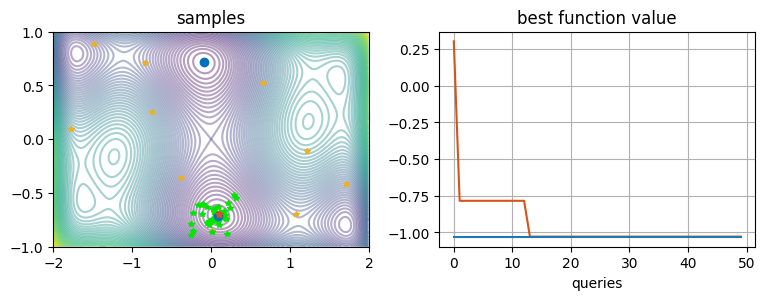

In [2]:
"""
2D examples solved by GLISp
    - with box constraints only
    - check examples with known constraints in the file 'glisp_known_constraints.py'
    - check examples with unknown constraints in the file 'glisp_unknown_constraints.py'

Notes:
    - The preference expression step may be
        - integrated/fed directly into GLISp
        - incrementally provided to GLISp
    - RBF surrogate is used
        - The user may choose to recalibrate the RBF parameters during the solving process
    - For exploration step, one may use the following methods:
        - IDW
        - probability of improvement
    Templates of the aforementioned solving procedures are noted in this file

Authors: A. Bemporad, M. Zhu
"""

import numpy as np
import matplotlib.pyplot as plt
from pyswarm import pso
from glis.solvers import GLISp

benchmark = "camelsixhumps"
# benchmark="ackley"


savefigs = False

if benchmark == "camelsixhumps":
    # Camel six-humps function
    lb = np.array([-2.0, -1.0])
    ub = np.array([2.0, 1.0])
    fun = lambda x: ((4.0 - 2.1 * x[0] ** 2 + x[0] ** 4 / 3.0) * x[0] ** 2 +
                     x[0] * x[1] + (4.0 * x[1] ** 2 - 4.0) * x[1] ** 2)
    xopt0 = np.array([[0.0898, -0.0898], [-0.7126, 0.7126]])  # unconstrained optimizers, one per column
    fopt0 = -1.0316  # unconstrained optimum
    max_evals = 50
    comparetol = 1e-4
    n_initial_random = 10

elif benchmark == "ackley":
    lb = -5.0 * np.ones(2)
    ub = 5.0 * np.ones(2)
    fun = lambda x: -20.0 * np.exp(-.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))) - np.exp(
        0.5 * (np.cos(2.0 * np.pi * x[0]) + np.cos(2.0 * np.pi * x[1]))) + np.exp(1.0) + 20.0

    # compute optimum/optimizer by PSO
    xopt0, fopt0 = pso(fun, lb, ub, swarmsize=200,
                       minfunc=1e-12, maxiter=10000)

    max_evals = 50
    comparetol = 1e-4
    n_initial_random = 10

max_prefs = max_evals - 1


####################################################################################
# Define synthetic preference function mapping (x1,x2) to {-1,0,1}
def pref_fun(x1, x2):
    f1 = fun(x1)
    f2 = fun(x2)
    if f1 <= f2 - comparetol:
        pref = -1
    elif f1 >= f2 + comparetol:
        pref = 1
    else:
        pref = 0
    return pref


##########################################


key = 3
np.random.seed(key)  # rng default for reproducibility
####################################################################################
print("Solve the problem by feeding the  preference expression step directly into the GLISp solver")
# Solve global optimization problem
# prob1 = GLISp(bounds=(lb, ub), n_initial_random=n_initial_random, acquisition_method="prob_improvement")
prob1 = GLISp(bounds=(lb, ub), n_initial_random=n_initial_random)

xopt1 = prob1.solve(pref_fun, max_prefs)
X1 = np.array(prob1.X)
fbest_seq1 = list(map(fun, X1[prob1.ibest_seq]))
##########################################

# Plot
print("Optimization finished. Draw the plot")
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
fig.tight_layout(pad=2, h_pad=2, w_pad=2)

[x_plot, y_plot] = np.meshgrid(np.arange(lb[0], ub[0], .01), np.arange(lb[1], ub[1], .01))
z_plot = np.zeros(x_plot.shape)
for i in range(0, x_plot.shape[0]):
    for j in range(0, x_plot.shape[1]):
        z_plot[i, j] = fun(np.array([x_plot[i, j], y_plot[i, j]]))

ax[0].contour(x_plot, y_plot, z_plot, 100, alpha=.4)
ax[0].plot(X1[:prob1.n_initial_random, 0], X1[:prob1.n_initial_random, 1], "*", color=[0.9258, 0.6914, 0.1250],
           markersize=4)
ax[0].plot(X1[prob1.n_initial_random:, 0], X1[prob1.n_initial_random:, 1], "*", color=[0, 0.9, 0], markersize=4)
ax[0].plot(xopt0[0], xopt0[1], "o", color=[0, 0.4470, 0.7410], markersize=6)
ax[0].plot(xopt1[0], xopt1[1], "*", color=[0.8500, 0.3250, 0.0980], markersize=6)
ax[0].set_xlim(lb[0], ub[0])
ax[0].set_ylim(lb[1], ub[1])
ax[0].set_title("samples")

ax[1].plot(np.arange(0, max_evals), fbest_seq1, color=[0.8500, 0.3250, 0.0980])
ax[1].plot(np.arange(0, max_evals), fopt0 * np.ones(max_evals))
ax[1].set_title("best function value")
ax[1].set_xlabel("queries")
ax[1].grid()

if savefigs:
    plt.savefig("glisp-1.png", dpi=300)
plt.show()

# np.random.seed(key)
# ####################################################################################
# print("Solve the problem incrementally (i.e., provide the preference at each iteration)")
# # solve same problem, but incrementally
# # prob2 = GLISp(bounds=(lb, ub), n_initial_random=n_initial_random, )
# prob2 = GLISp(bounds=(lb, ub), n_initial_random=n_initial_random, acquisition_method="prob_improvement")

# xbest2, x2 = prob2.initialize()  # get first two random samples
# for k in range(max_prefs):
#     pref = pref_fun(x2, xbest2)  # evaluate preference
#     x2 = prob2.update(pref)
#     xbest2 = prob2.xbest
# X2 = np.array(prob2.X[:-1])
# xopt2 = xbest2
# fbest_seq2 = list(map(fun, X2[prob2.ibest_seq]))


# ##########################################
# # assert np.linalg.norm(X1-X2)==0.0 and np.all(xopt1==xopt2)


# ####################################################################################
# # Smart synthetic preference function that avoids recomputing the same value
# # fun(xbest) multiple times:
# def pref_fun_smart(x1, x2):
#     pref_fun_smart.X.append(x1)
#     f1 = fun(x1)
#     pref_fun_smart.F.append(f1)

#     X = np.array(pref_fun_smart.X)
#     i = np.where(np.all(np.abs(X - x2) == 0.0, axis=1))[0]  # does x2 already exist in list ?
#     if i.size == 0:
#         pref_fun_smart.X.append(x2)
#         f2 = fun(x2)
#         pref_fun_smart.F.append(f2)
#     else:
#         f2 = pref_fun_smart.F[i[0].item()]

#     if f1 <= f2 - comparetol:
#         pref = -1
#     elif f1 >= f2 + comparetol:
#         pref = 1
#     else:
#         pref = 0
#     return pref


# pref_fun_smart.X = list()  # initialize preference function
# pref_fun_smart.F = list()

# np.random.seed(key)
# ##########################################
# print("Solve the problem use an alternative synthetic pref fun.")
# prob3 = GLISp(bounds=(lb, ub), n_initial_random=n_initial_random, RBFcalibrate=True)
# xopt3 = prob3.solve(pref_fun_smart, max_prefs)
# X3 = np.array(prob3.X)
# fbest_seq3 = list(map(fun, X3[prob3.ibest_seq]))

# # assert np.linalg.norm(X1-X3)==0.0 and np.all(xopt1==xopt3)

In [3]:
prob1.ibest

13

# now with coffee

In [4]:

key = 3
np.random.seed(key)  # rng default for reproducibility
print("Solve the problem incrementally (i.e., provide the preference at each iteration)")
n_initial_random = 10
lb = np.array([
    0, # coffee
    0, # size
    1 # ground
    ])
ub = np.array([
    9, # coffee
    12, # size
    7 # ground
    ])

Solve the problem incrementally (i.e., provide the preference at each iteration)


In [5]:
prob2 = GLISp(bounds=(lb, ub), n_initial_random=n_initial_random, RBFcalibrate=True, acquisition_method="prob_improvement")
xbest2, x2 = prob2.initialize()  # get first two random samples
xbest2, x2


(array([8.11147994, 9.14094502, 4.58744635]),
 array([0.40446107, 9.63711503, 5.93925903]))

In [6]:
def coffee_des(arr):
    if arr[0] < 4:
        return f'coffee min + {str(round(arr[0], 1))}'
    elif arr[0] <8:
        return f'coffee med_right + {str(round(arr[0]-4, 1))}'
    else:
        return f'coffee max - {str(round(9-arr[0], 1))}'

def size_des(arr):
    if arr[1] < 6:
        return f'size min + {str(round(arr[1], 1))}'
    elif arr[1] <11:
        return f'size med + {str(round(arr[1]-6, 1))}'
    else:
        return f'size max - {str(round(12-arr[1], 1))}'



def ground(arr):
    return(f'ground {str(round(arr[2], 1))}')

def cup_asker(arr1, arr2):
    print('первый стакан')
    print(coffee_des(arr1))
    print(size_des(arr1))
    print(ground(arr1))

    print('второй стакан')
    print(coffee_des(arr2))
    print(size_des(arr2))
    print(ground(arr2))

    print('1, если первый стакан вкуснее, -1 если второй и 0, если не отличить')


cup_asker(xbest2, x2)

первый стакан
coffee max - 0.9
size med + 3.1
ground 4.6
второй стакан
coffee min + 0.4
size med + 3.6
ground 5.9
1, если первый стакан вкуснее, -1 если второй и 0, если не отличить


In [7]:
pref = 1
x2 = prob2.update(pref)
xbest2 = prob2.xbest
cup_asker(xbest2, x2)

Query #  1 (no improvement): testing x = [ 0.4045,  9.6371,  5.9393]
первый стакан
coffee max - 0.9
size med + 3.1
ground 4.6
второй стакан
coffee min + 3.0
size min + 0.6
ground 1.3
1, если первый стакан вкуснее, -1 если второй и 0, если не отличить


In [8]:
pref = 1
x2 = prob2.update(pref)
xbest2 = prob2.xbest
cup_asker(xbest2, x2)

Query #  2 (no improvement): testing x = [ 2.9755,  0.5723,  1.3098]
первый стакан
coffee max - 0.9
size med + 3.1
ground 4.6
второй стакан
coffee med_right + 3.3
size med + 1.7
ground 5.6
1, если первый стакан вкуснее, -1 если второй и 0, если не отличить


In [9]:
X2 = np.array(prob2.X[:-1])
xopt2 = xbest2
fbest_seq2 = list(map(fun, X2[prob2.ibest_seq]))


In [10]:
fbest_seq2

[113785.52380124207, 113785.52380124207, 113785.52380124207]

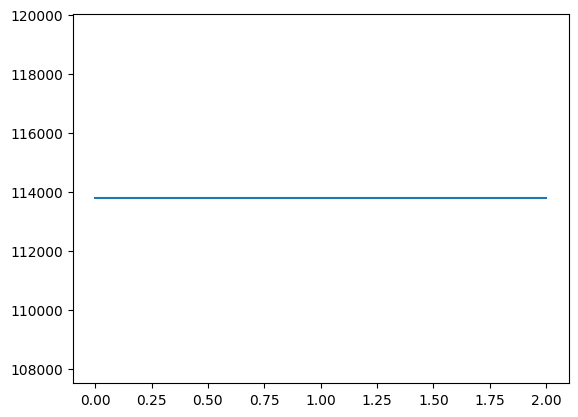

In [11]:
plt.plot(fbest_seq2)